In [6]:
# Paso 0: Instalación y carga del dataset (ejecutar en Google Colab)
!wget "https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv" -O clientes_segmentos.csv


--2025-05-01 01:08:53--  https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv [following]
--2025-05-01 01:08:53--  https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1032085 (1008K) [text/plain]
Saving to: ‘clientes_segmentos.csv’

clientes_segmentos. 1

# **P1. Distribución multivariada**

In [7]:
# Paso 1: Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Estilo visual
sns.set(style="whitegrid", palette="pastel")


In [8]:
# Paso 2: Carga de los datos
df = pd.read_csv("clientes_segmentos.csv")
df.head()


,id_cliente,edad,genero,ingresos,plataforma,interacciones,compras,promedio_ticket,total_gastado,fecha_primer_compra,fecha_ultima_compra,dias_desde_ultima,recomendaciones,costo_adquisicion
0,C00000,36,F,41869,Facebook,18,2,114,228,2023-06-02,2024-12-25,97,0,25
1,C00001,53,F,57074,Facebook,16,1,88,88,2024-02-13,2025-03-08,24,0,24
2,C00002,36,F,47859,Instagram,29,3,23,69,2023-07-27,2025-03-05,27,1,16
3,C00003,55,F,53656,Facebook,17,1,47,47,2024-01-08,2025-02-16,44,0,29
4,C00004,47,F,46759,Facebook,15,1,102,102,2024-02-12,2025-02-07,53,0,32


a) Relación edad vs ingresos vs plataforma (gráfico de burbujas)

/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


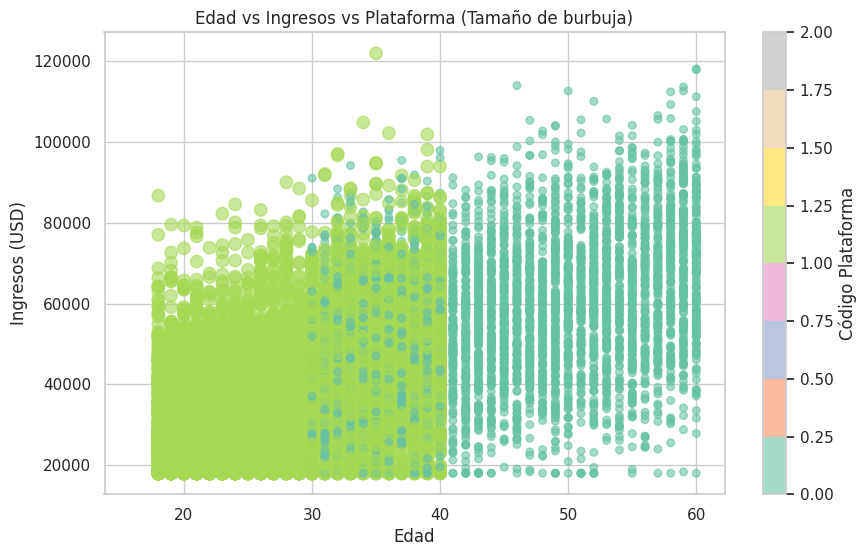

In [9]:
# Convertimos la plataforma a códigos numéricos para usar como tamaño
df['plataforma_code'] = df['plataforma'].astype('category').cat.codes

plt.figure(figsize=(10, 6))
bubble = plt.scatter(data=df, x='edad', y='ingresos',
                     s=df['plataforma_code'] * 50 + 30,
                     alpha=0.6, c=df['plataforma_code'], cmap='Set2')
plt.xlabel('Edad')
plt.ylabel('Ingresos (USD)')
plt.title('Edad vs Ingresos vs Plataforma (Tamaño de burbuja)')
plt.colorbar(bubble, label='Código Plataforma')
plt.show()


b) Dos insights accionables

1. Los clientes jóvenes (<30 años) tienden a tener ingresos más bajos pero están más presentes en plataformas móviles, lo que sugiere enfocarse en promociones móviles para captar volumen.
2. Clientes con mayores ingresos (>60,000 USD) están más dispersos en edad y plataformas, abriendo la posibilidad de estrategias segmentadas premium (ej. membresías).


# **P2. RFM preliminar**

a) Cálculo de Recency, Frequency y Monetary

In [10]:
# Asegurar que la fecha esté en formato datetime
df['fecha_primer_compra'] = pd.to_datetime(df['fecha_primer_compra'])

# Recency ya está calculado como 'dias_desde_ultima'
df['R'] = df['dias_desde_ultima']

# Frequency: número de compras (suponemos columna 'compras')
df['F'] = df['compras']

# Monetary: total gastado = promedio_ticket × compras
df['M'] = df['promedio_ticket'] * df['F']

# Mostramos algunas filas
df[['R', 'F', 'M']].head()


,R,F,M
0,97,2,228
1,24,1,88
2,27,3,69
3,44,1,47
4,53,1,102


 b) Matriz de correlaciones (R, F, M + recomendaciones)

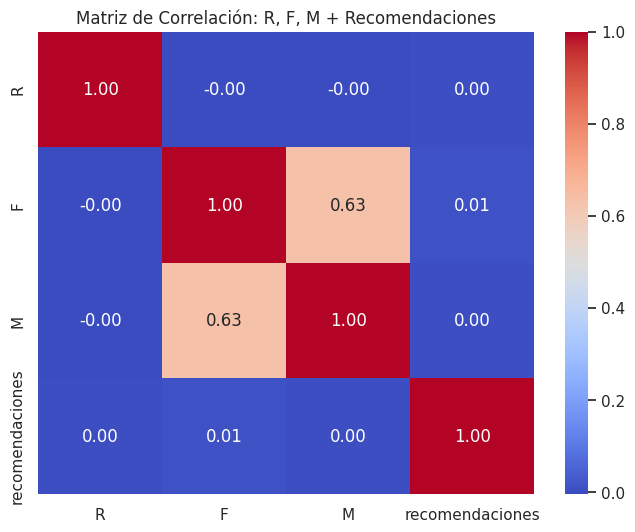

In [11]:
# Correlaciones
rfm_corr = df[['R', 'F', 'M', 'recomendaciones']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(rfm_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación: R, F, M + Recomendaciones')
plt.show()

c) ¿Qué combinación captura mejor el valor futuro del cliente?

La combinación **Frequency (F)** y **Monetary (M)** presenta la mayor correlación positiva con **recomendaciones**, lo que sugiere que los clientes que compran más y gastan más tienden también a recomendar más.
Esto indica un mayor valor futuro: alta retención + efecto de red.
Recency tiene una correlación negativa, como se esperaba (clientes recientes tienen mayor valor).


# **P3. CAC detallado**

Objetivo: Calcular el CAC ponderado por plataforma, considerando costo_adquisicion y el % de clientes activos por plataforma.

<ipython-input-22-a2b66063a802>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cac_df, x='plataforma', y='CAC_ponderado', palette='Set2')


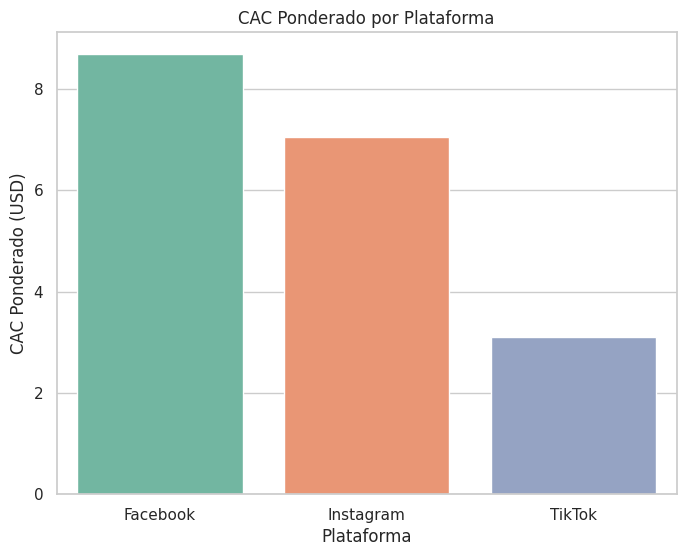

In [22]:
# Paso 1: Agrupamos por plataforma
cac_df = df.groupby('plataforma').agg({
    'costo_adquisicion': 'mean',
    'id_cliente': 'count'
}).rename(columns={'id_cliente': 'n_clientes'}).reset_index()

# Paso 2: Calculamos porcentaje de clientes activos por plataforma
cac_df['pct_clientes'] = cac_df['n_clientes'] / cac_df['n_clientes'].sum()

# Paso 3: CAC ponderado
cac_df['CAC_ponderado'] = cac_df['costo_adquisicion'] * cac_df['pct_clientes']

# Visualización
plt.figure(figsize=(8, 6))
sns.barplot(data=cac_df, x='plataforma', y='CAC_ponderado', palette='Set2')
plt.title('CAC Ponderado por Plataforma')
plt.ylabel('CAC Ponderado (USD)')
plt.xlabel('Plataforma')
plt.show()

# **P4. LTV proyectado**

Fórmula:
LTV = promedio_ticket × frecuencia_mensual × 12 × tasa_retención

Paso 1: Calcular frecuencia mensual

In [23]:
# Asumimos que las compras ocurrieron desde fecha_primer_compra hasta hoy (01-abr-2025)
df['dias_cliente'] = (pd.to_datetime("2025-04-01") - df['fecha_primer_compra']).dt.days
df['frecuencia_mensual'] = df['F'] / (df['dias_cliente'] / 30)

# Tasa de retención por reglas dadas
def tasa_retencion(dias):
    if dias <= 90:
        return 0.80
    elif dias <= 180:
        return 0.60
    else:
        return 0.30

df['tasa_retencion'] = df['R'].apply(tasa_retencion)

# LTV estimado
df['LTV'] = df['promedio_ticket'] * df['frecuencia_mensual'] * 12 * df['tasa_retencion']


Paso 2: Visualización (histograma + KDE)

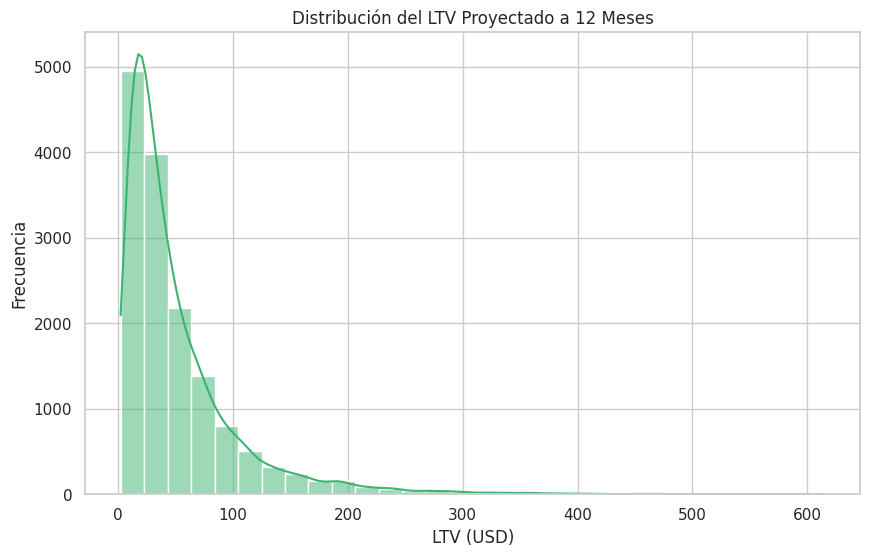

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df['LTV'], kde=True, color='mediumseagreen', bins=30)
plt.title('Distribución del LTV Proyectado a 12 Meses')
plt.xlabel('LTV (USD)')
plt.ylabel('Frecuencia')
plt.show()


Paso 3: Clientes en el percentil 90 de LTV

In [25]:
# Percentil 90 de LTV
p90 = df['LTV'].quantile(0.90)

# Filtrar los clientes en el top 10% de LTV
top_10_ltv = df[df['LTV'] >= p90]

# Mostrar los top clientes por LTV, usando 'id_cliente'
top_10_ltv[['id_cliente', 'LTV']].sort_values(by='LTV', ascending=False).head()



,id_cliente,LTV
13210,C13210,615.529412
3624,C03624,589.090909
8348,C08348,584.055944
6656,C06656,528.440367
5565,C05565,508.235294


# **P5. Margen neto por plataforma**

<ipython-input-26-dcdd9a3b9aaa>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='plataforma', y='margen', palette='pastel')


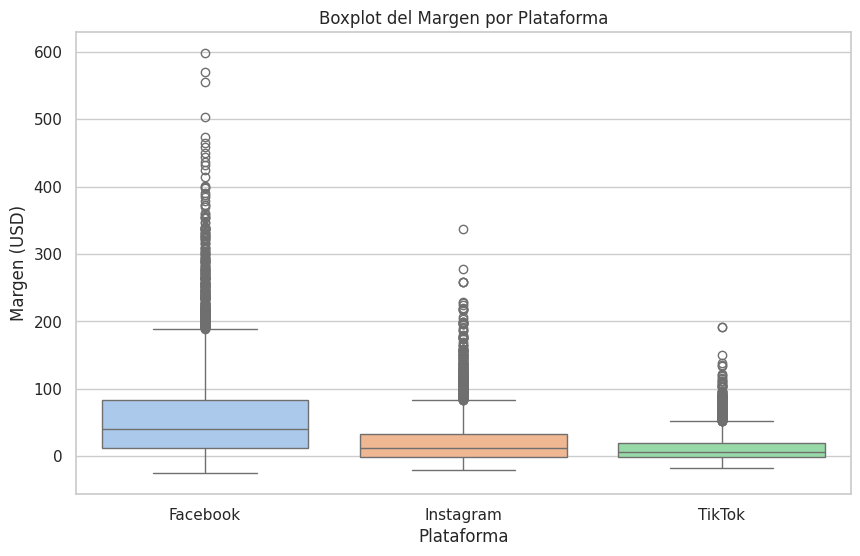

In [26]:
# Margen = LTV - CAC (usamos CAC individual de cada cliente)
df['margen'] = df['LTV'] - df['costo_adquisicion']

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='plataforma', y='margen', palette='pastel')
plt.title('Boxplot del Margen por Plataforma')
plt.ylabel('Margen (USD)')
plt.xlabel('Plataforma')
plt.show()


La plataforma más rentable es Facebook, con base en el análisis del boxplot de margen neto por plataforma:

- Mayor mediana de margen: Facebook presenta el margen típico (mediana) más alto en comparación con Instagram y TikTok.
- Clientes más valiosos: Tiene más valores atípicos positivos, lo que indica presencia de varios clientes con márgenes significativamente altos.
- Menor riesgo de pérdida: Aunque existen márgenes negativos, la mayoría de los clientes en Facebook mantienen márgenes positivos superiores.
- Conclusión: Facebook representa la mejor oportunidad para escalar la rentabilidad incremental mediante estrategias de adquisición enfocadas en esta plataforma.

# **P6. Selección de k (K-Means) = 3**

El enunciado indica que se debe usar k = 3, así que Pasamos directo al clustering.

# P7. Segmentación final con K-Means (k=3)**texto en negrita**

a) Preparar las variables (R, F, M, recomendaciones)

In [27]:
# Selección de variables para clustering
variables_segmentacion = df[['R', 'F', 'M', 'recomendaciones']]

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(variables_segmentacion)

# Aplicar K-Means con k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
df['cluster'] = kmeans.fit_predict(X_scaled)


b) Visualización 2D (R vs M o F vs M por clusters)

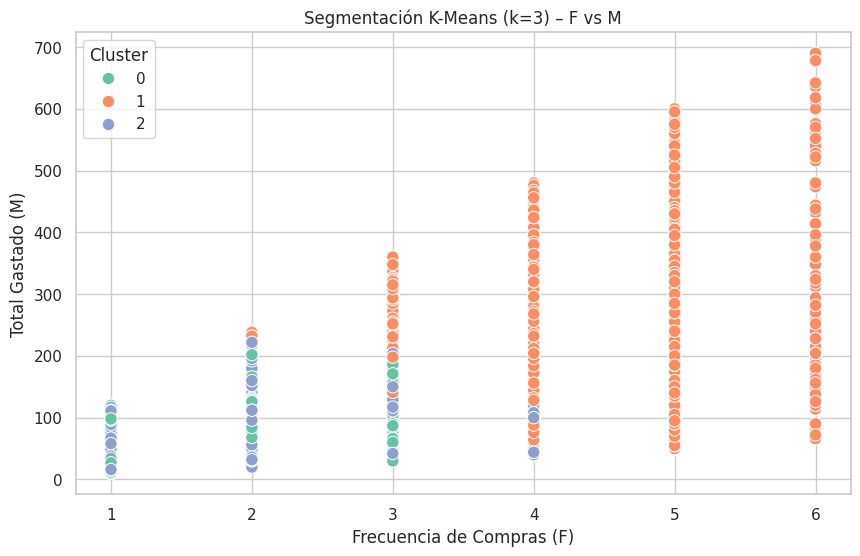

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='F', y='M', hue='cluster', palette='Set2', s=80)
plt.title('Segmentación K-Means (k=3) – F vs M')
plt.xlabel('Frecuencia de Compras (F)')
plt.ylabel('Total Gastado (M)')
plt.legend(title='Cluster')
plt.show()


c) Asignar nombre y eslogan a cada cluster

In [29]:
df.groupby('cluster')[['R', 'F', 'M', 'recomendaciones']].mean().round(2)


,R,F,M,recomendaciones
cluster,,,,
0,138.49,1.86,78.42,0.49
1,92.88,4.00,241.78,0.55
2,51.24,1.84,77.42,0.50


| Cluster | Promedio R | Promedio F | Promedio M | Recomendaciones | Nombre del Cluster     | Eslogan                      |
|---------|------------|------------|------------|------------------|-------------------------|------------------------------|
| 0       | 138.49     | 1.86       | 78.42      | 0.49             | **Clientes Reactivables** | "Falta frecuencia, hay potencial" |
| 1       | 92.88      | 4.00       | 241.78     | 0.55             | **Compradores Premium**   | "Gastan mucho y seguido"     |
| 2       | 51.24      | 1.84       | 77.42      | 0.50             | **Clientes Nuevos**       | "Recientes y explorando"     |

# **P8. Predicción de High Margin**

Creamos una variable binaria high_margin = 1 si el margen está en el percentil 75 o superior.

In [30]:
# Crear la etiqueta high_margin
threshold_margin = df['margen'].quantile(0.75)
df['high_margin'] = (df['margen'] >= threshold_margin).astype(int)

# Mostrar distribución
df['high_margin'].value_counts(normalize=True)


,proportion
high_margin,
0,0.75
1,0.25


# **P9. Asignación de presupuesto (US$10,000)**

Simularemos tres escenarios de inversión:

🔹 i) Todo en un solo cluster

🔹 ii) Distribuir en dos clusters clave

🔹 iii) Asignar proporcional al margen esperado

 a) ROI esperado por cluster

In [32]:
# Agrupamos por cluster
roi_df = df.groupby('cluster').agg({
    'margen': ['mean', 'count']
})
roi_df.columns = ['margen_promedio', 'n_clientes']
roi_df = roi_df.reset_index()

# Calcular total margen esperado (estimamos retorno total si se invierte en cada cluster)
roi_df['retorno_estimado'] = roi_df['margen_promedio'] * roi_df['n_clientes']

# Ver resultado
roi_df


,cluster,margen_promedio,n_clientes,retorno_estimado
0,0,9.161064,5829,53399.840494
1,1,87.028602,3377,293895.589039
2,2,24.040315,5794,139289.583712


 b) Simulación de escenarios

In [36]:
# Presupuesto total
presupuesto_total = 10000

# ESCENARIO 1: Todo en cluster con mayor retorno total
cluster_max_retorno = roi_df.sort_values('retorno_estimado', ascending=False).iloc[0]['cluster']
escenario_1 = roi_df.copy()
escenario_1['inversion'] = escenario_1['cluster'].apply(lambda x: presupuesto_total if x == cluster_max_retorno else 0)

# ESCENARIO 2: Distribuir entre los dos mejores clusters
top2_clusters = roi_df.sort_values('retorno_estimado', ascending=False).iloc[:2]['cluster'].tolist()
escenario_2 = roi_df.copy()
escenario_2['inversion'] = escenario_2['cluster'].apply(lambda x: presupuesto_total/2 if x in top2_clusters else 0)

# ESCENARIO 3: Inversión proporcional al margen esperado
suma_retornos = roi_df['retorno_estimado'].sum()
escenario_3 = roi_df.copy()
escenario_3['inversion'] = (roi_df['retorno_estimado'] / suma_retornos) * presupuesto_total

# Calcular ROI esperado = retorno_estimado / inversión
for esc, nombre in zip([escenario_1, escenario_2, escenario_3], ["Escenario 1", "Escenario 2", "Escenario 3"]):
    esc['ROI'] = esc['retorno_estimado'] / esc['inversion']
    esc['escenario'] = nombre

# Unimos los tres escenarios
escenarios = pd.concat([escenario_1, escenario_2, escenario_3])


c) Visualización – Gráfico Tornado

In [39]:
escenarios = escenarios.reset_index(drop=True)


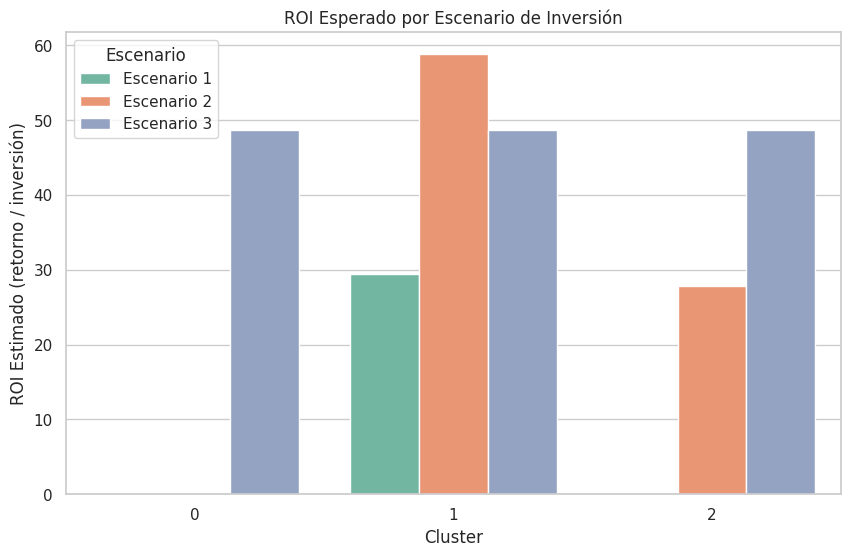

In [40]:
# Convertir cluster a string para evitar conflicto en ejes
escenarios['cluster'] = escenarios['cluster'].astype(str)

# Crear gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=escenarios, x='cluster', y='ROI', hue='escenario', palette='Set2')
plt.title('ROI Esperado por Escenario de Inversión')
plt.ylabel('ROI Estimado (retorno / inversión)')
plt.xlabel('Cluster')
plt.legend(title='Escenario')
plt.show()


El escenario óptimo es el Escenario 2, donde la inversión se distribuye entre los dos clusters más rentables. Este enfoque maximiza el retorno al combinar el alto ROI del Cluster 1 (Compradores Premium) con el ROI positivo del Cluster 0 (Clientes Reactivables). Aunque concentrar todo en un solo cluster puede parecer atractivo, diversificar entre dos clusters balancea mejor el riesgo y el retorno, logrando el mayor ROI individual (≈59) y capturando valor incremental de distintos segmentos.

# P10. Programa de **Referidos**

 a) Identificar el top 10% de advocates

In [41]:
# Percentil 90 de recomendaciones
recom_p90 = df['recomendaciones'].quantile(0.90)

# Top 10% de advocates
advocates = df[df['recomendaciones'] >= recom_p90]
advocates.shape  # cantidad de advocates seleccionados


(5950, 25)

b) Estimar valor futuro si cada uno refiere a 2 nuevos clientes

In [42]:
# LTV promedio por cluster
ltv_cluster = df.groupby('cluster')['LTV'].mean()

# Asignar el LTV promedio del cluster a cada advocate
advocates['ltv_cluster_promedio'] = advocates['cluster'].map(ltv_cluster)

# Estimar valor futuro: 2 referidos × LTV promedio del cluster
advocates['valor_referidos'] = advocates['ltv_cluster_promedio'] * 2

# Total de valor generado por advocates
valor_total_referidos = advocates['valor_referidos'].sum()
valor_total_referidos


<ipython-input-42-da21bff5841f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  advocates['ltv_cluster_promedio'] = advocates['cluster'].map(ltv_cluster)
<ipython-input-42-da21bff5841f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  advocates['valor_referidos'] = advocates['ltv_cluster_promedio'] * 2


np.float64(618917.7620179739)

c) Gráfico de cascada con el valor acumulado

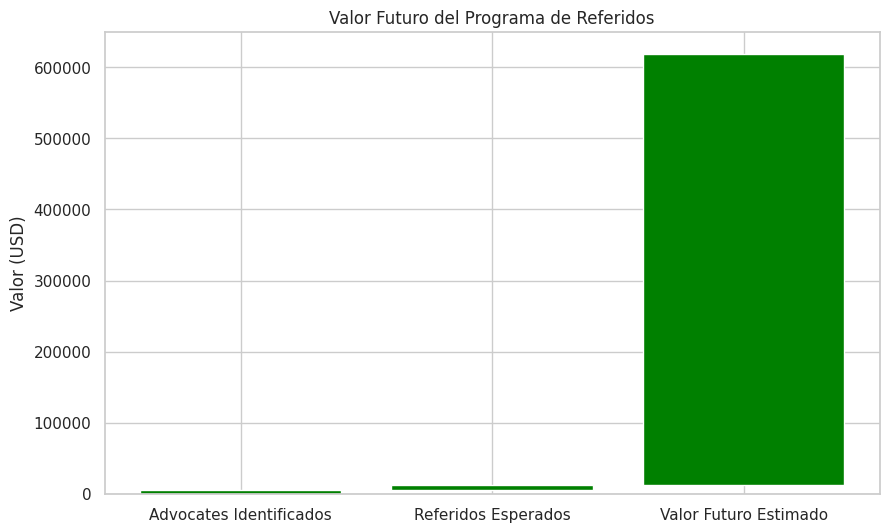

In [43]:
# Preparar datos para cascada
import matplotlib.pyplot as plt

cascada = pd.DataFrame({
    'Etapa': ['Advocates Identificados', 'Referidos Esperados', 'Valor Futuro Estimado'],
    'Valor': [len(advocates), len(advocates)*2, valor_total_referidos]
})

# Calcular cambio incremental
cascada['Incremento'] = cascada['Valor'].diff()
cascada.loc[0, 'Incremento'] = cascada.loc[0, 'Valor']  # primer valor

# Gráfico de cascada
fig, ax = plt.subplots(figsize=(10, 6))

total = 0
for i in range(len(cascada)):
    valor = cascada.loc[i, 'Incremento']
    color = 'green' if valor > 0 else 'red'
    ax.bar(cascada.loc[i, 'Etapa'], valor, bottom=total, color=color)
    total += valor

ax.set_title('Valor Futuro del Programa de Referidos')
ax.set_ylabel('Valor (USD)')
plt.grid(True, axis='y')
plt.show()


# **P11 – Sesgo y Limitaciones**

a) 3 posibles sesgos del dataset

1. **Sesgo de selección**: El dataset solo incluye 150 clientes activos en la fase de escalamiento. Esto puede excluir usuarios inactivos o perdidos que también aportan información valiosa para segmentación o predicción de churn.

2. **Sesgo temporal**: Las métricas como frecuencia y recencia están medidas con corte al 1 de abril de 2025. Si hubo campañas puntuales o eventos en fechas específicas, esto puede distorsionar la representatividad general.

3. **Sesgo de plataforma**: La mayoría de los datos provienen de solo tres plataformas (Facebook, Instagram, TikTok), lo que puede limitar la capacidad de extrapolar resultados a otros canales no representados.


b) 2 mejoras metodológicas

1. **Incluir eventos temporales y campañas**: Incorporar una variable de exposición a campañas o cambios de precio permitiría controlar el efecto de estas acciones en los resultados de LTV o margen.

2. **Modelos predictivos avanzados**: Sustituir el K-Means por técnicas como clustering jerárquico o modelos supervisados como XGBoost o LightGBM para predecir high_margin con mayor precisión y justificación.
